# TP OpenMP - October 2022

Florian Rascoussier

Bastien Barbe

Ce notebook constitue une étude comparative des méthodes de parallélisation CUDA sur GPU pour différentes applications.

## Part 1 : Pi

Ce programme calcule la valeur de pi à la précision renseignée par l'utilisateur.

### Compilation

In [1]:
# script params
EXEC: bool = True

In [2]:
# create /bin if it does not exist
!mkdir -p bin

# compile the programs
!nvcc -o bin/tp_cuda_part_1_pi_multiblock_1_threadperblock tp_cuda_part_1_pi_multiblock_1_threadperblock.cu -O3
!nvcc -o bin/tp_cuda_part_1_pi_multithread tp_cuda_part_1_pi_multithread.cu -O3
!nvcc -o bin/tp_cuda_part_1_pi_multithread_shared tp_cuda_part_1_pi_multithread_shared.cu -O3
!nvcc -o bin/tp_cuda_part_1_pi_multithread_full_reduction tp_cuda_part_1_pi_multithread_full_reduction.cu -O3 -g

# cuda-memcheck ./bin/tp_cuda_part_1_pi_basic -T 1000 -N 100000

### Performance evaluation

In [3]:
# global vars
csv_result_file = "stats.csv"
csv_headers = {
    'version': str,
    'B': int,
    'T': int,
    'N': int,
    'runtime' : float
}

B_values = [1, 32, 64, 128, 256]
N_values = [100, 1000, 10000, 100000, 1000000]
T_values = [1, 32, 64, 128, 256]

# heatmap for N, B, T

color_class = {
    "onethreadperblock": "red",
    "multithread": "orange",
    "multithread_shared": "blue",
    "multithread_reduction": "green"
}

repeats = 3

In [19]:
import os
import subprocess

def delete_old_csv_file():
    try:
        os.remove(csv_result_file)
    except OSError:
        pass

def create_csv_file():
    print(f"Creating NEW CSV file ({csv_result_file})")
    f = open(csv_result_file, "w")
    f.write(",".join(csv_headers.keys()) + "\n")
    f.close()

# execute the programs
def run_program(
    program_filepath: str, B: int, T: int, N: int
):
    args = (program_filepath, 
        "-B", str(B), 
        "-T", str(T),
        "-N", str(N)
    )
    popen = subprocess.Popen(args, stdout=subprocess.PIPE)
    popen.wait()

print("Program executions")
def exec_instances():
    for B in B_values:
        for T in T_values:
            for N in N_values:
                print(f" + Running programs (B: {B}, T: {T}, N: {N})")
                for _ in range(repeats):
                    run_program("bin/tp_cuda_part_1_pi_multiblock_1_threadperblock", B,T,N)
                    run_program("bin/tp_cuda_part_1_pi_multithread", B,T,N)
                    run_program("bin/tp_cuda_part_1_pi_multithread_shared", B,T,N)
                    run_program("bin/tp_cuda_part_1_pi_multithread_full_reduction", B,T,N)
                    print("*", end = '')
                print()

if EXEC:
    delete_old_csv_file()
    create_csv_file()
    exec_instances()
else: 
    print(f"WARN: EXEC = {EXEC}. No C++ program execution.")



Program executions
Creating NEW CSV file (stats.csv)
 + Running programs (B: 1, T: 1, N: 100)
**********
 + Running programs (B: 1, T: 1, N: 1000)
**********
 + Running programs (B: 1, T: 1, N: 10000)
**********
 + Running programs (B: 1, T: 1, N: 100000)
**********
 + Running programs (B: 1, T: 1, N: 1000000)
******

### Performance analysis

,version,B,T,N,runtime
0,onethreadperblock,1,1,100,0.073810
1,multithread,1,1,100,0.057917
2,multithread_shared,1,1,100,0.066592
3,multithread_reduction,1,1,100,0.052076
4,onethreadperblock,1,1,100,0.066400
5,multithread,1,1,100,0.054795
6,multithread_shared,1,1,100,0.056721
7,multithread_reduction,1,1,100,0.080153
8,onethreadperblock,1,1,100,0.059506
9,multithread,1,1,100,0.052796


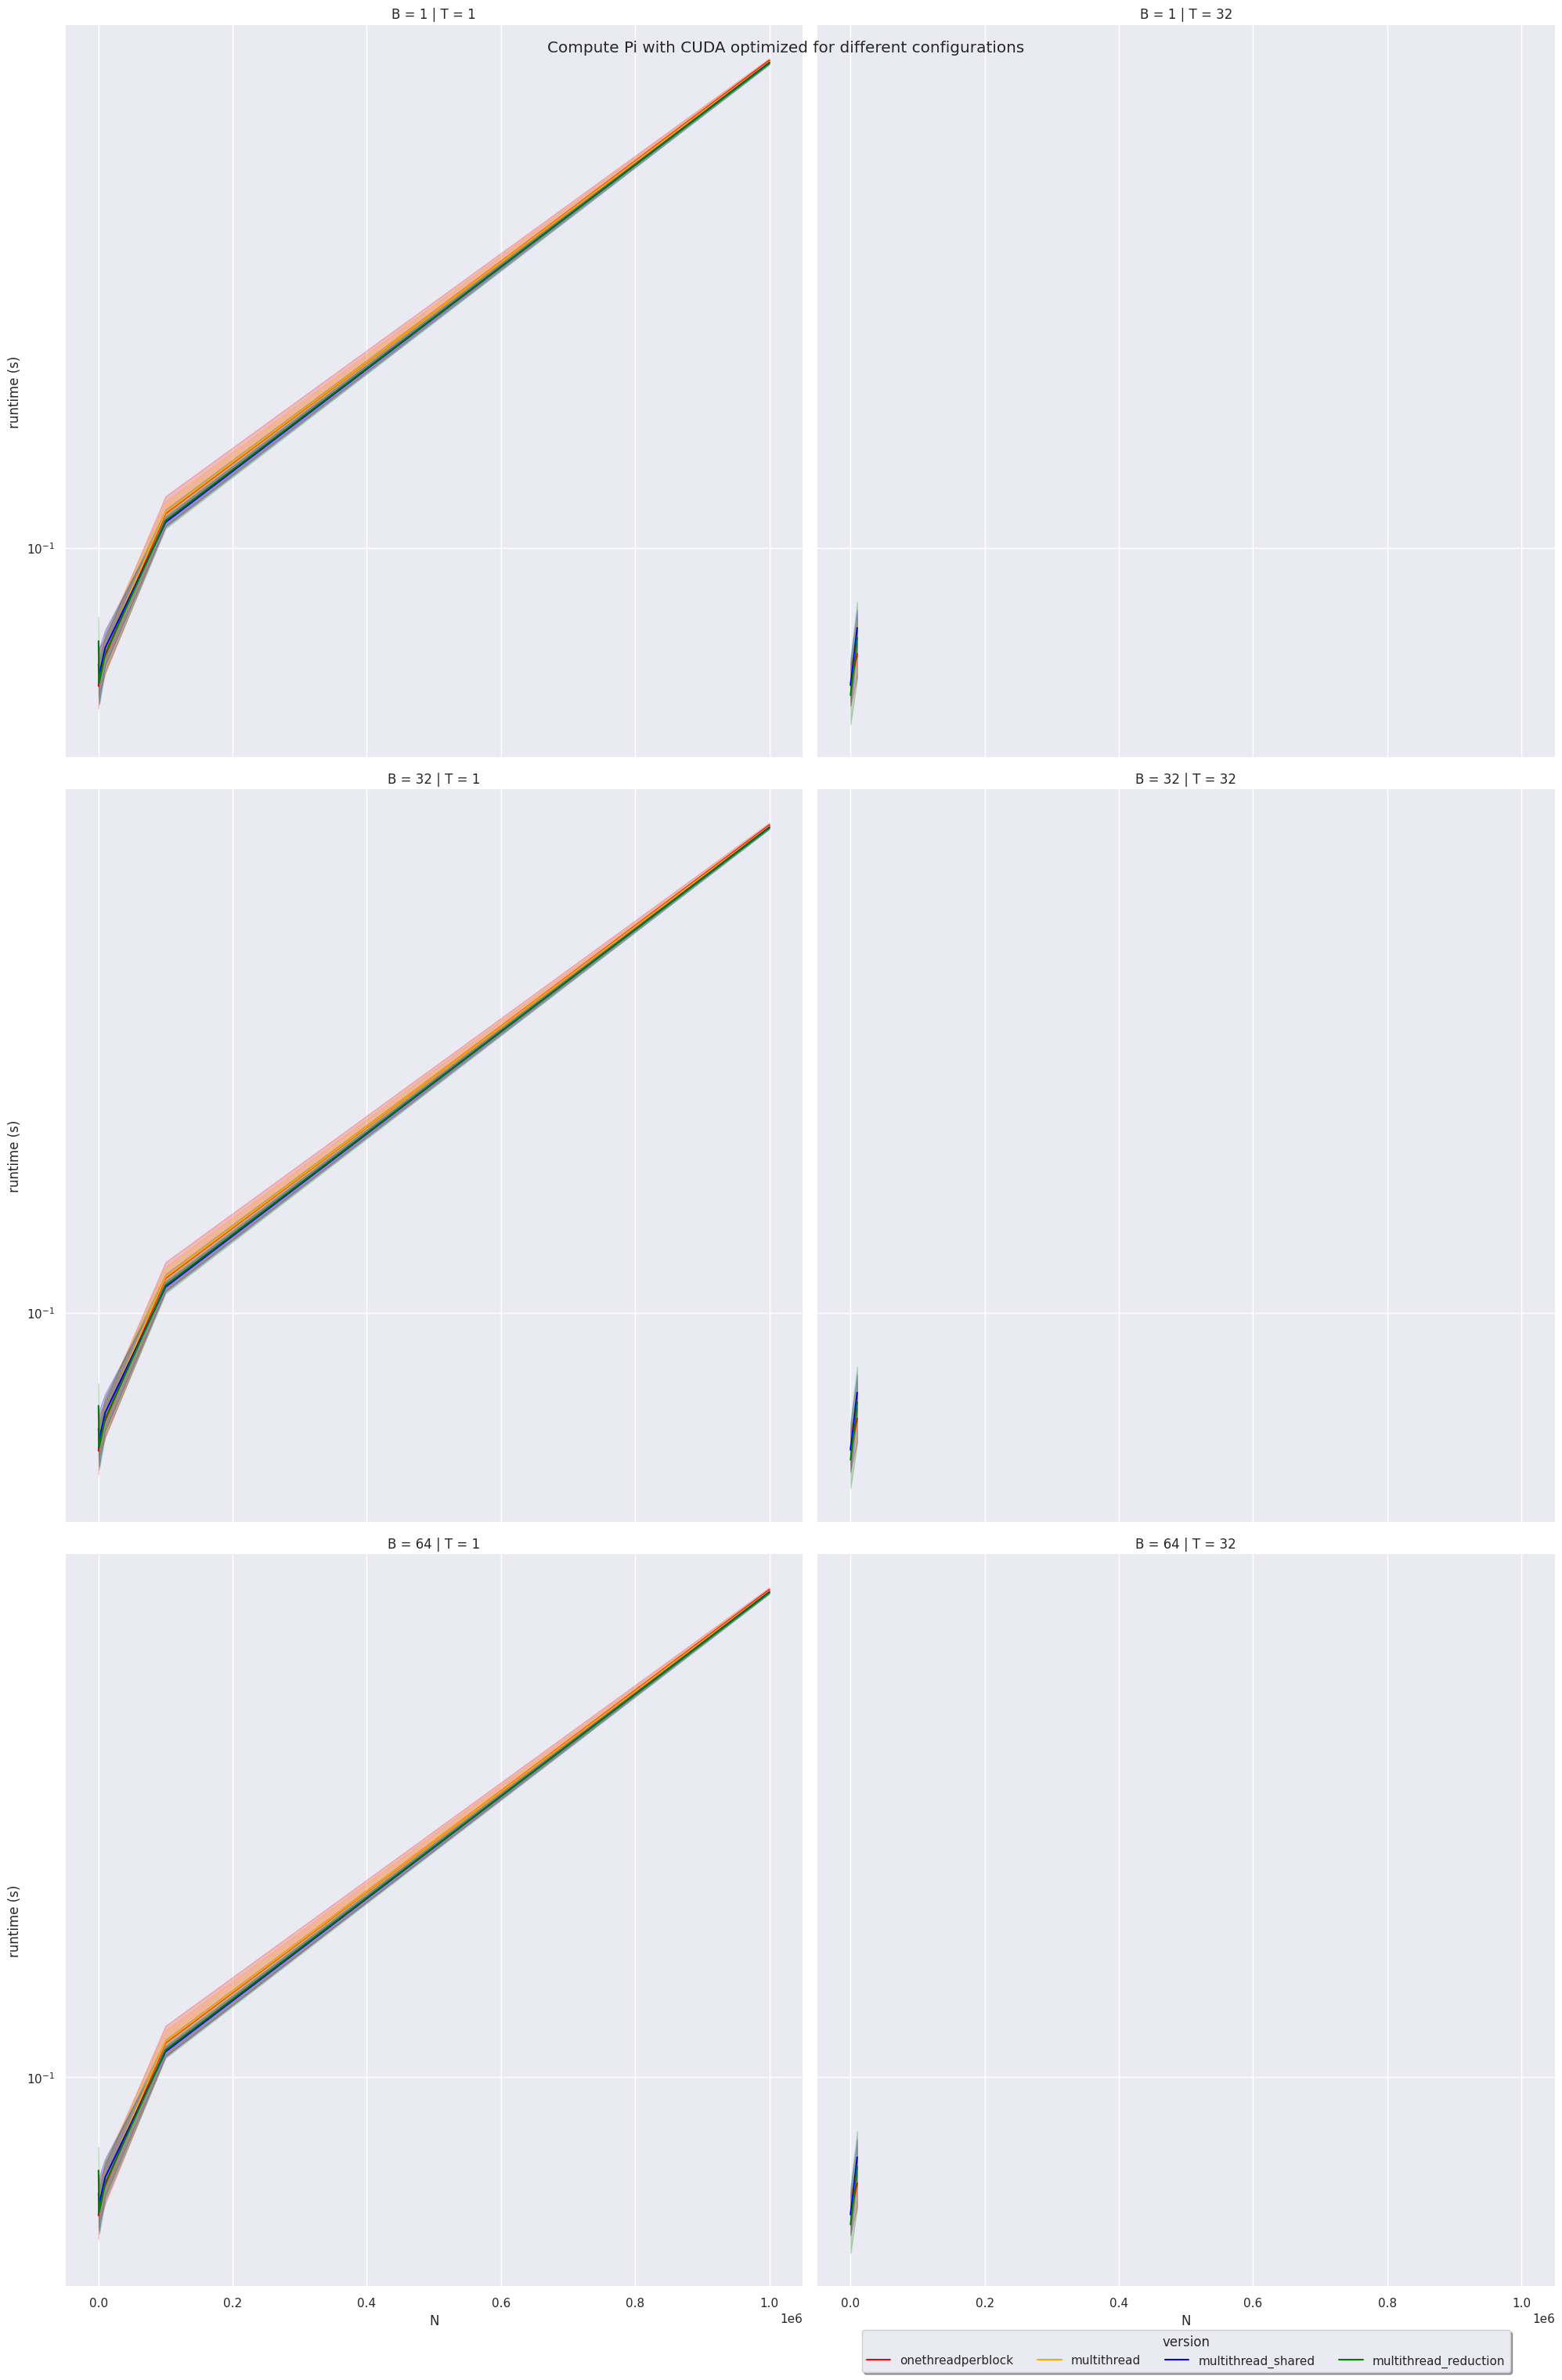

In [29]:
# superposed big graph
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from numpy import genfromtxt
import pandas as pd
import seaborn as sns

sns.set()


df = pd.read_csv(
    csv_result_file,
    header=0, # line number of header
    dtype=csv_headers
)
display(df.head(10))

# filter out 0 runtime values
df = df[df.runtime > 0]



# display the graph
def display_graph(N: int, df):
    fig, ax = plt.subplots(figsize=(18,16))
    fig.suptitle(f"Superposed Graphs of Chained Matrix multiplication for different precisions, with square matrices of size {N}x{N}")

    for i in range(0, len(color_class.keys())):
        # print version graph data
        graph_version = list(color_class.keys())[i]
        df_plot_0 = df[df['version'] == graph_version]

        g0 = sns.lineplot(
            ax=ax,
            data=df_plot_0, 
            x="N",
            y="runtime", 
            hue="version",
            palette=color_class,
            style="version",
        )
        g0.set(yscale="log")
        g0.set(xlabel="Matrix dimensions N=M=P", ylabel="runtime (s)")
        g00 = sns.scatterplot(
            ax=ax,
            data=df_plot_0, 
            x="N",
            y="runtime", 
            hue="version",
            palette=color_class,
            legend=False,
        )
        g00.set(yscale="log")

    plt.legend()
    plt.show()

#fig, ax = plt.subplots(figsize=(18,16))
#fig.suptitle(f"Compute Pi with CUDA optimized for different configurations")

# display legend for hue inside the subplots
g = sns.FacetGrid(
    data=df, 
    hue="version",
    col="T",
    row="B",
    palette=color_class, 
    height=10, 
    legend_out=True
).map(sns.lineplot, "N", "runtime").set(yscale="log").set(xlabel="N", ylabel="runtime (s)")


# add legend for x and y axis
plt.xlabel("N")
plt.ylabel("runtime (s)")

# add graph title
g.figure.suptitle(f"Compute Pi with CUDA optimized for different configurations")

# display legend for hue outside the subplots above the graph
plt.legend(
    title="version",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),
    fancybox=True,
    shadow=True,
    ncol=5
)


### Discussion